In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


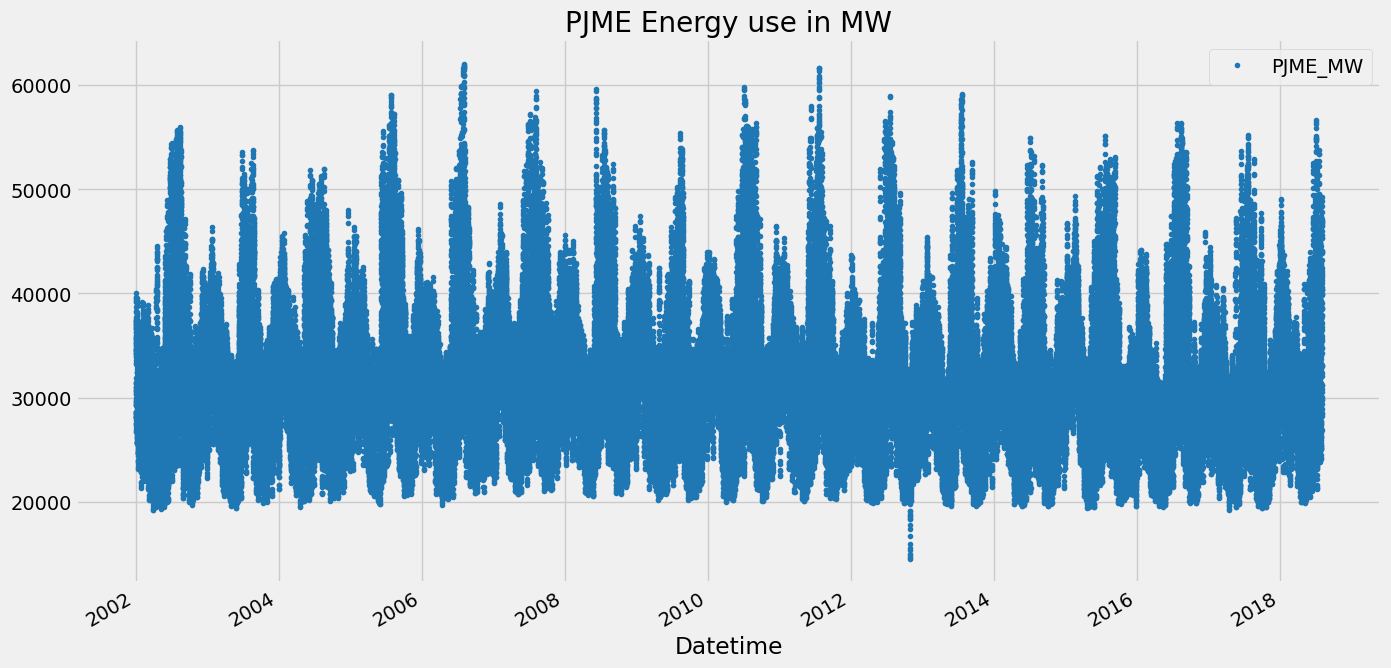

In [6]:
df.plot(style = '.',
        color = color_pal[0],
        figsize = (15,8),
        title = 'PJME Energy use in MW'
)
plt.show()

# Outlier Analysis and removal

<Axes: ylabel='Frequency'>

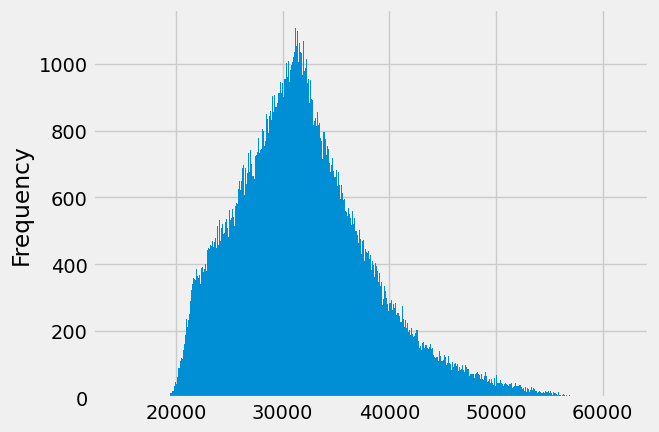

In [7]:
df["PJME_MW"].plot(kind = "hist",bins = 500)

<Axes: xlabel='Datetime'>

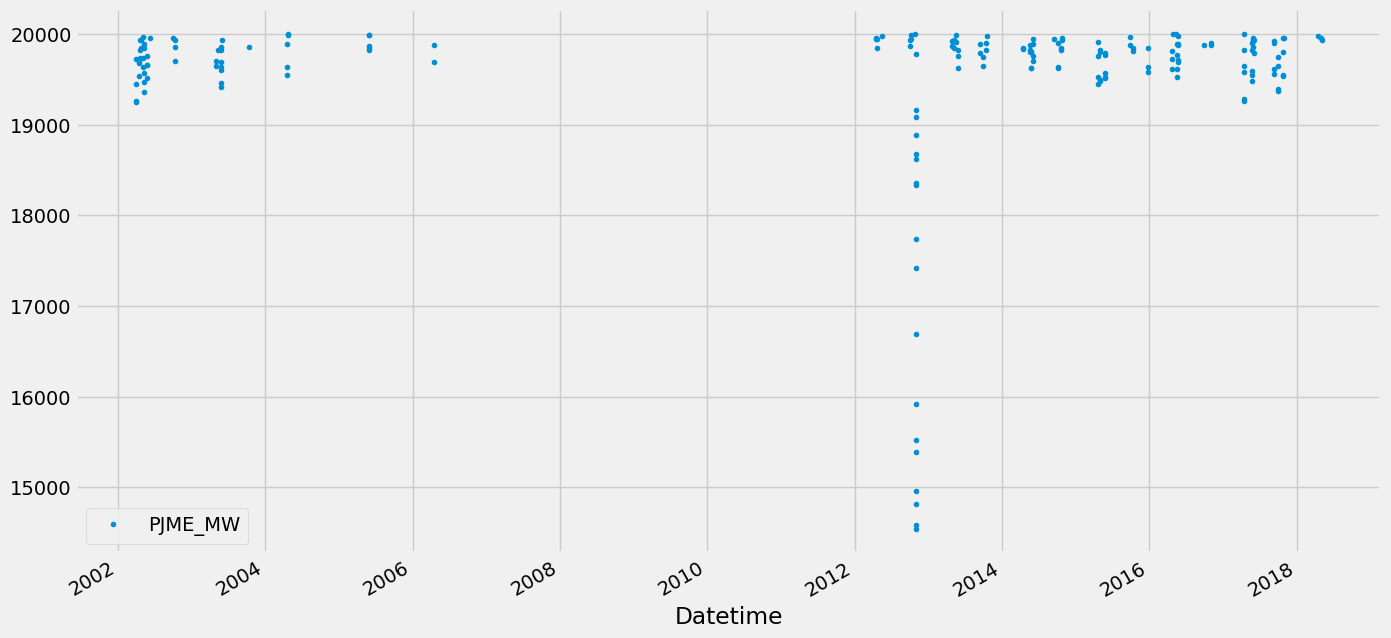

In [8]:
df.query('PJME_MW < 20000').plot(figsize=(15,8), style = ".")

<Axes: xlabel='Datetime'>

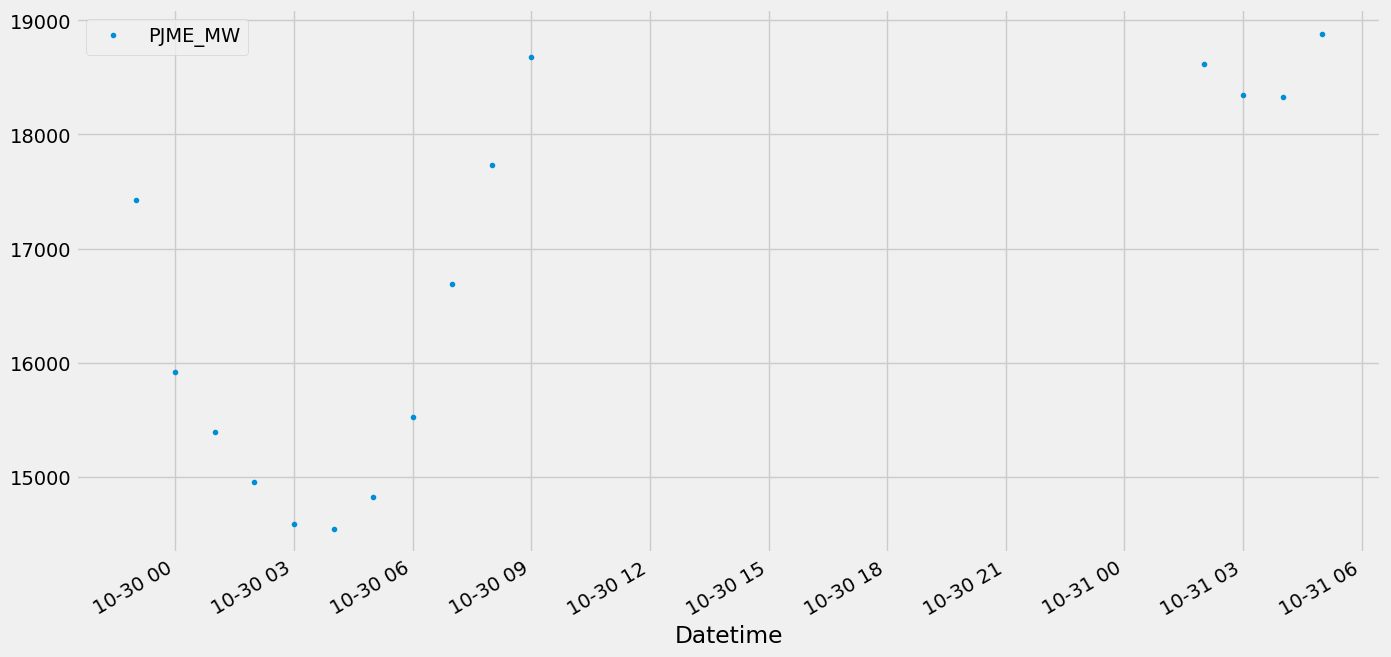

In [9]:
df.query('PJME_MW < 19000').plot(figsize=(15,8), style = ".")

In [10]:
df1 = df.query('PJME_MW > 19000').copy()

In [11]:
df1.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [12]:
df1.index < '01-01-2015'

array([ True,  True,  True, ..., False, False, False])

In [13]:
train = df1.iloc[df1.index < '01-01-2015']
test = df1.iloc[df1.index >= '01-01-2015']

<Axes: title={'center': 'Data train/test split'}, xlabel='Datetime'>

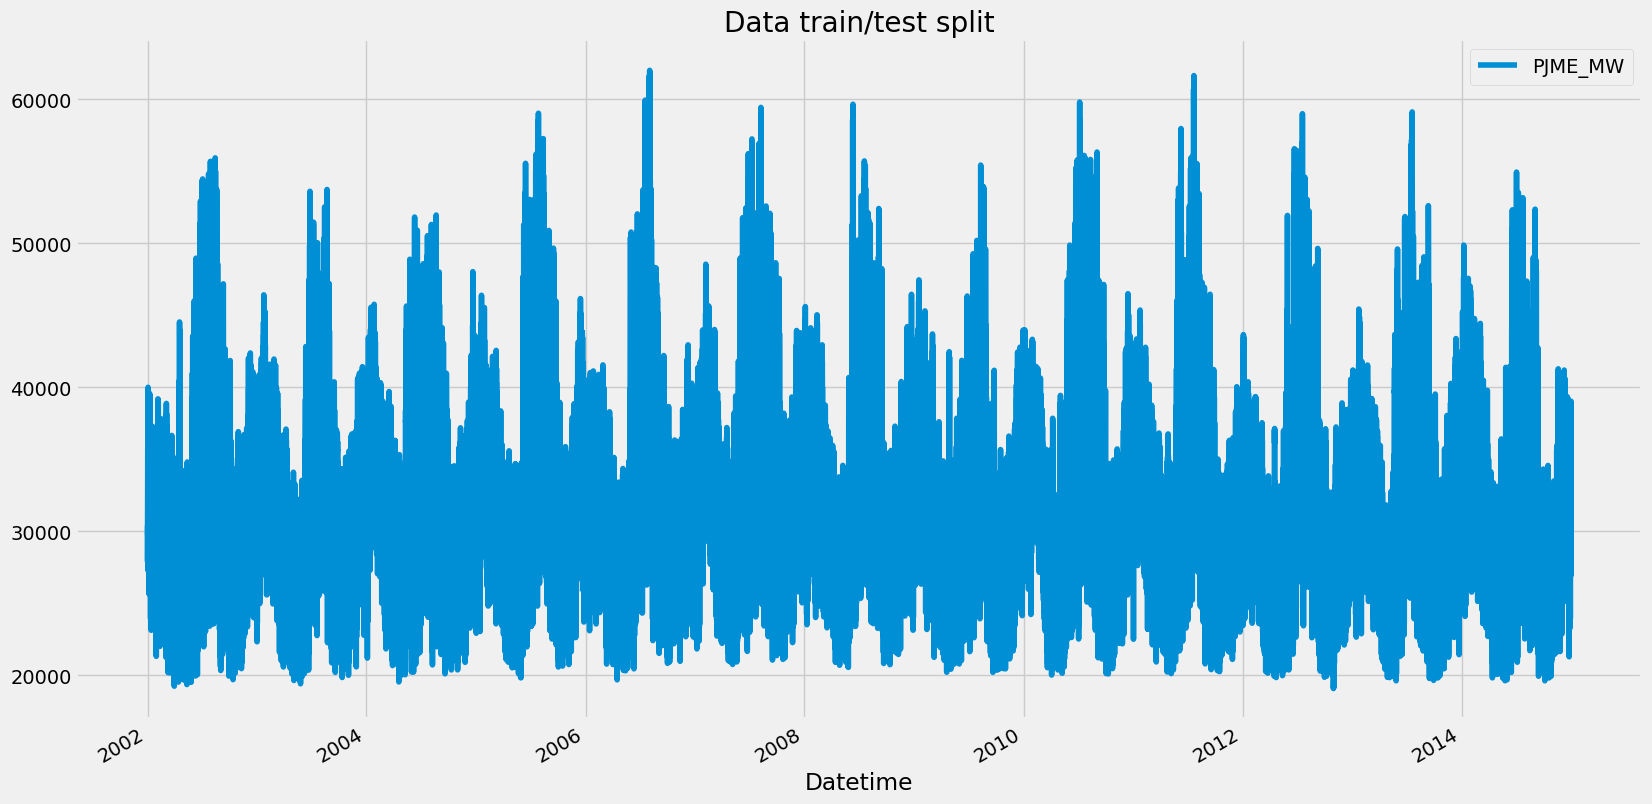

In [14]:
fig, ax = plt.subplots(figsize = (18,10))
train.plot(ax = ax, label = "train data", title= "Data train/test split")

<Axes: title={'center': 'Data train/test split'}, xlabel='Datetime'>

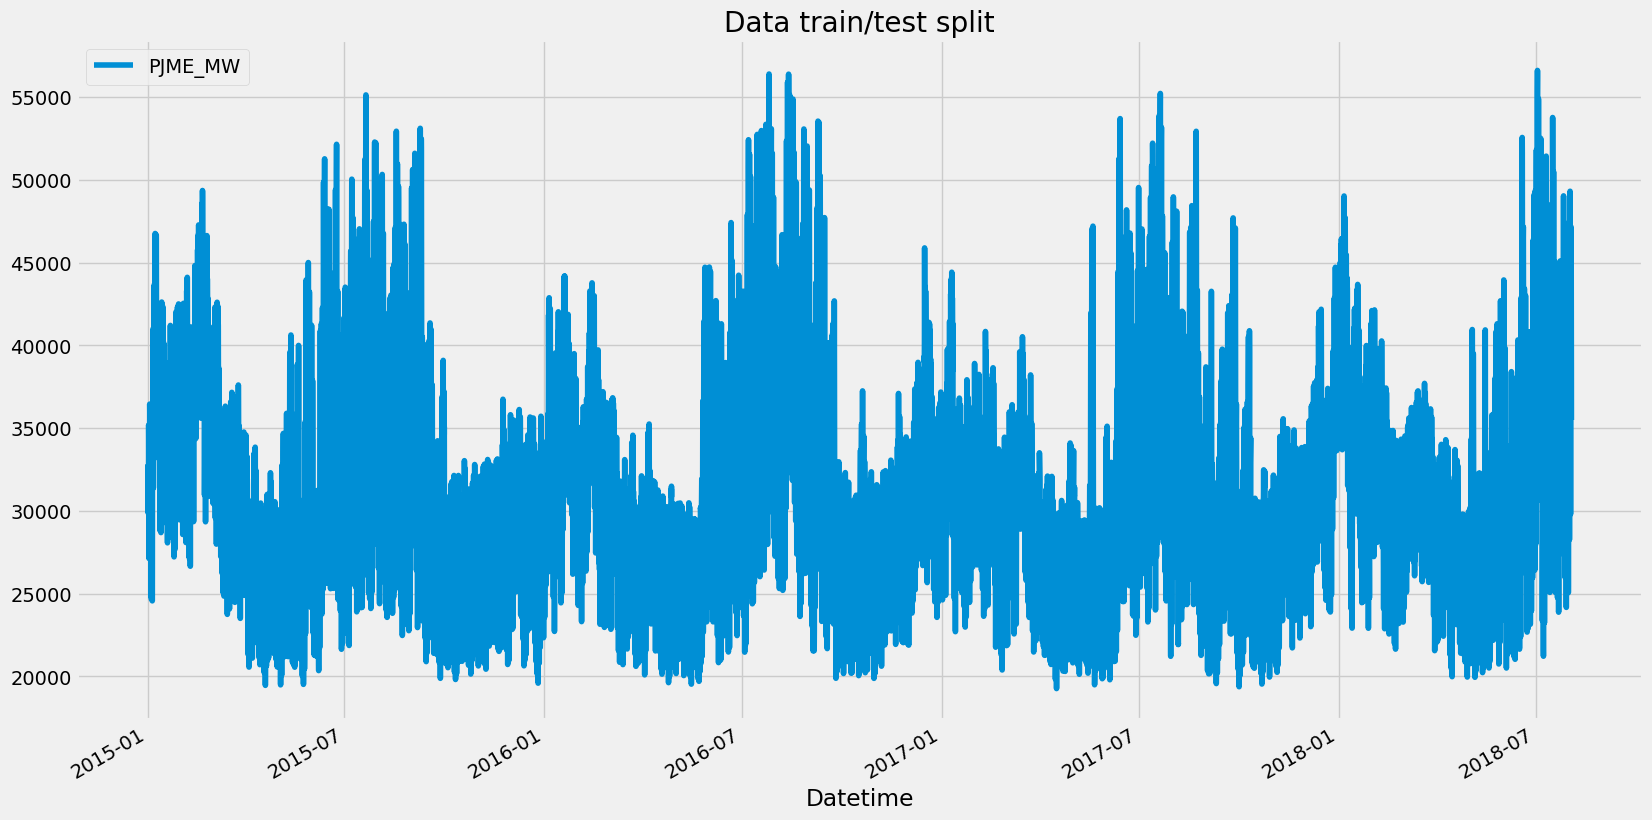

In [15]:
fig, ax = plt.subplots(figsize = (18,10))
test.plot(ax = ax, label = "test data", title= "Data train/test split")

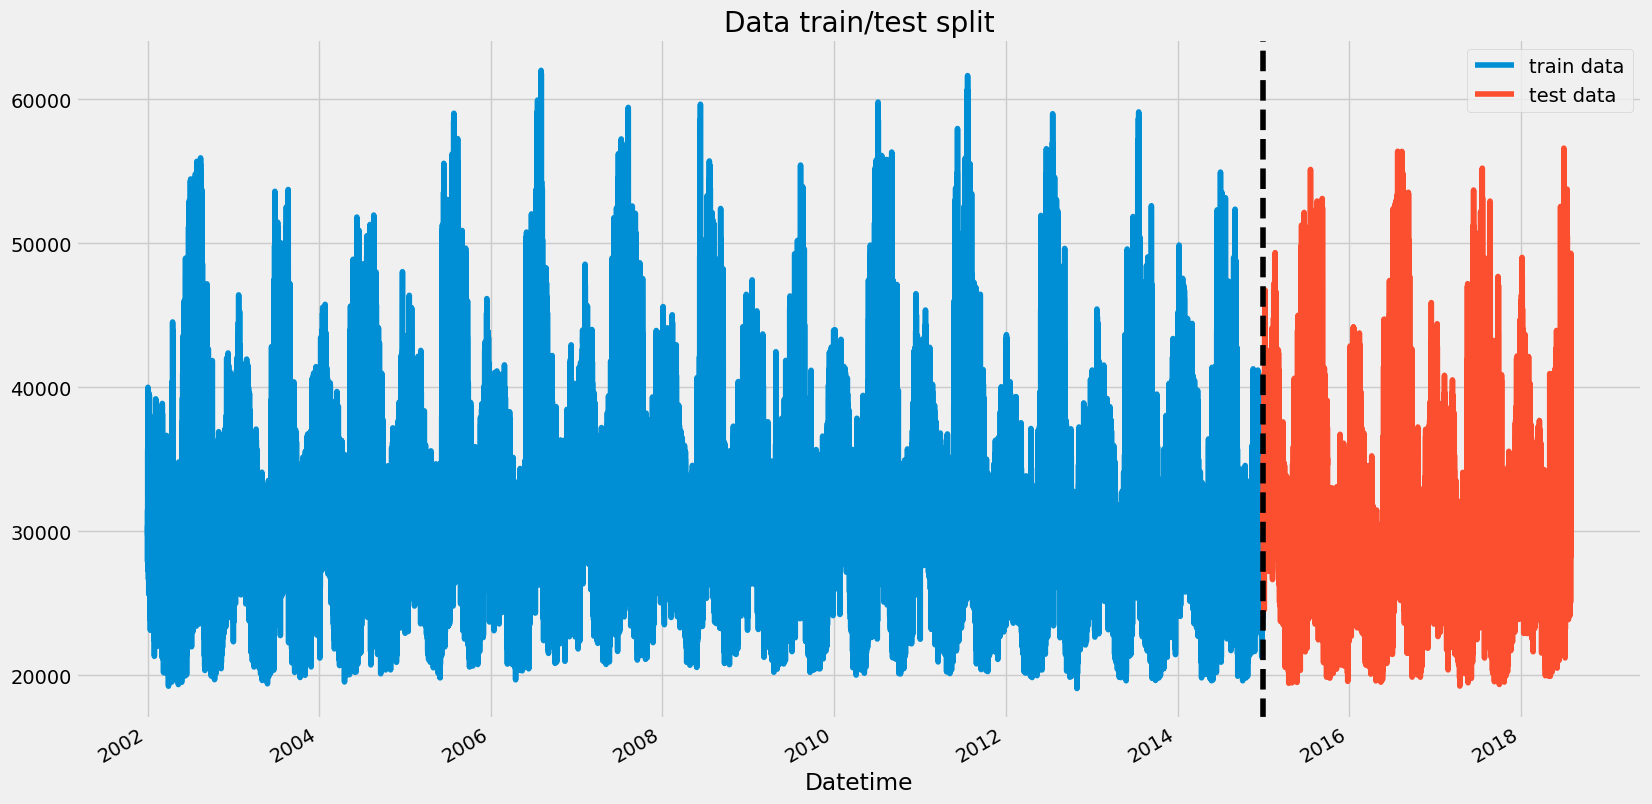

In [16]:
fig, ax = plt.subplots(figsize = (18,10))
train.plot(ax = ax)
test.plot(ax = ax)
ax.axvline('01-01-2015', ls = "--", color = "black")
plt.legend(["train data", "test data"])
plt.title("Data train/test split")
plt.show()

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
tss = TimeSeriesSplit(n_splits= 5, gap= 24, test_size= 24*365*1)

In [19]:
df1 = df1.sort_index()
df1.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [20]:
for train_idx, val_idx in tss.split(df1):
    break
train_idx

array([     0,      1,      2, ..., 101524, 101525, 101526])

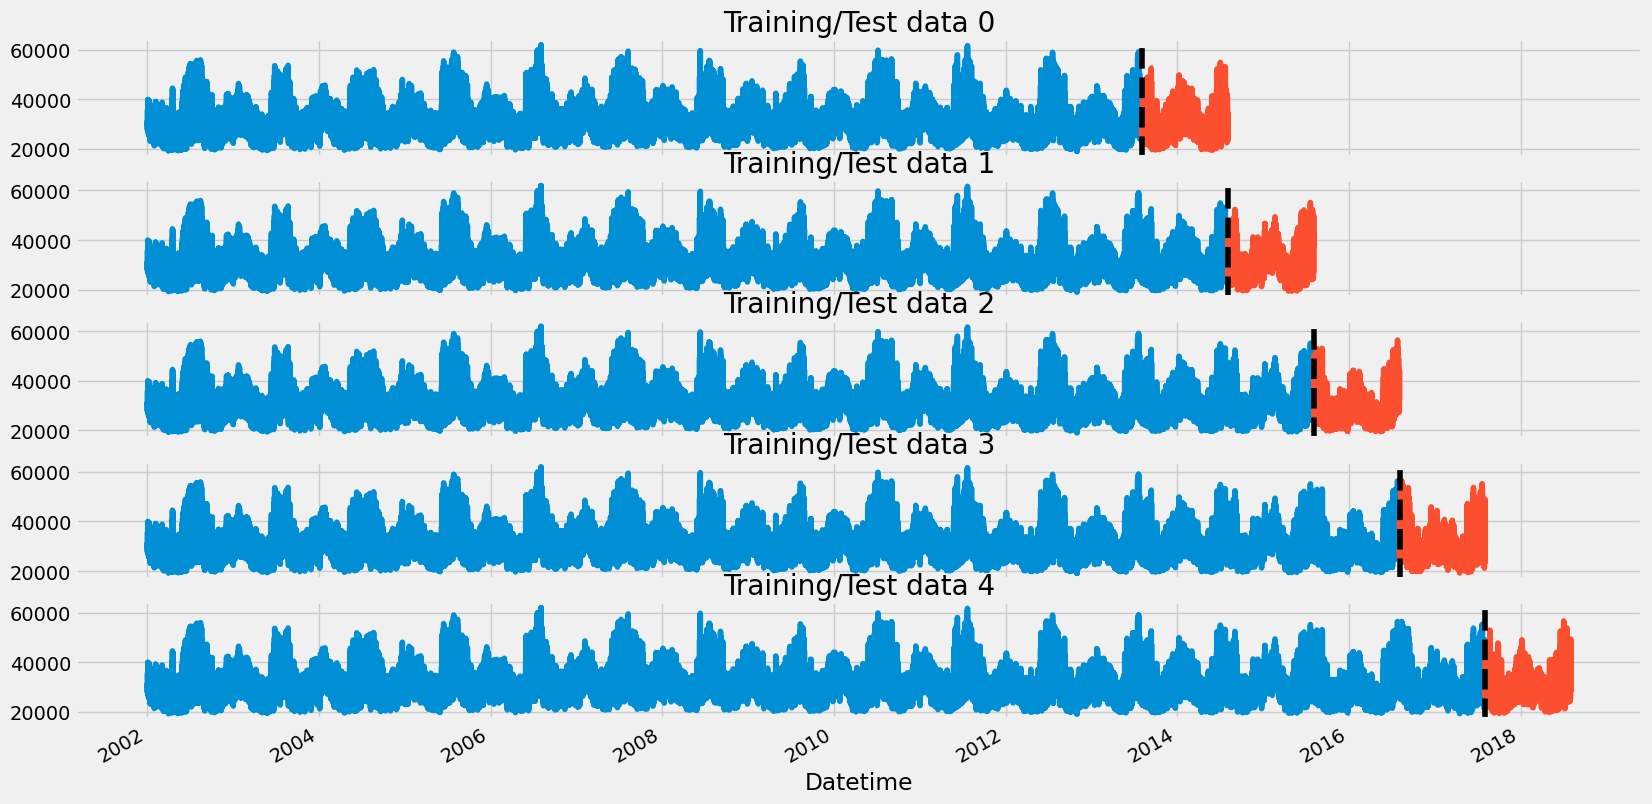

In [21]:
fig, axs = plt.subplots(5,1,figsize = (18,10), sharex= True)

fold = 0
for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    train["PJME_MW"].plot(ax = axs[fold], label = "Training data", title = f"Training/Test data {fold}")
    test["PJME_MW"].plot(ax = axs[fold], label = "Testing data")
    axs[fold].axvline(test.index.min(), ls = "--", color = "black")
    fold += 1
plt.show()

In [22]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    df["dayofweek"] = df.index.dayofweek
    df["dayofmonth"] = df.index.day
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.isocalendar().week
    return df

# lag features

In [23]:
def add_lags(df):
    target_map = df["PJME_MW"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [24]:
target_map = df["PJME_MW"].to_dict()

In [25]:
df1 = create_features(df1)

In [26]:
df1 = add_lags(df1)

In [27]:
df1.head()

,PJME_MW,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,2002,1,1,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,2002,1,1,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,2002,1,1,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,2002,1,1,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,2002,1,1,1,1,1,NaN,NaN,NaN


In [28]:
df1.sample(5)

,PJME_MW,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2015-09-13 20:00:00,29543.0,20,9,2015,3,6,13,256,37,28330.0,29682.0,29951.0
2014-02-04 23:00:00,35226.0,23,2,2014,1,1,4,35,6,34175.0,31156.0,37500.0
2016-08-28 18:00:00,46325.0,18,8,2016,3,6,28,241,34,43205.0,41306.0,43693.0
2017-09-12 01:00:00,22850.0,1,9,2017,3,1,12,255,37,25887.0,23372.0,23068.0
2017-04-13 17:00:00,27477.0,17,4,2017,2,3,13,103,15,27265.0,28017.0,28597.0


In [29]:
df1.tail()

,PJME_MW,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,8,2018,3,3,2,214,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,8,2018,3,3,2,214,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,8,2018,3,3,2,214,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,8,2018,3,3,2,214,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,8,2018,3,4,3,215,31,33539.0,32094.0,31695.0


In [30]:
df1.columns

Index(['PJME_MW', 'hour', 'month', 'year', 'quarter', 'dayofweek',
       'dayofmonth', 'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size= 24*365*1, gap =24)
df1 = df1.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = [ 'hour', 'month', 'year', 'quarter', 'dayofweek',
       'dayofmonth', 'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3']
    TARGET = "PJME_MW"
    
    X_train = train[FEATURES]
    X_test = test[FEATURES]
    
    y_train = train[TARGET]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                          n_estimator = 500,
                          early_stopping_rounds = 50,
                          max_depth = 50,
                          laerning_rate = 0.01)
    
    reg.fit(X_train,y_train, 
            eval_set = [(X_train,y_train),(X_test,y_test)],
            verbose = 100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[0]	validation_0-rmse:23274.82712	validation_1-rmse:22696.01384


C:\Users\Preetam\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "laerning_rate", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-rmse:0.00343	validation_1-rmse:4170.42599
[0]	validation_0-rmse:23232.61439	validation_1-rmse:22968.49272


C:\Users\Preetam\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:56:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "laerning_rate", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-rmse:0.00342	validation_1-rmse:3824.36411
[0]	validation_0-rmse:23203.36028	validation_1-rmse:21855.21057


C:\Users\Preetam\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:58:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "laerning_rate", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[58]	validation_0-rmse:1.68414	validation_1-rmse:4124.73523
[0]	validation_0-rmse:23129.76213	validation_1-rmse:22495.92508


C:\Users\Preetam\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "laerning_rate", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-rmse:1.80112	validation_1-rmse:4221.75172
[0]	validation_0-rmse:23086.28610	validation_1-rmse:22448.01311


C:\Users\Preetam\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "laerning_rate", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-rmse:2.44577	validation_1-rmse:4558.98316


In [33]:
print(preds)
print(score)

[array([40046.26 , 37784.81 , 33722.08 , ..., 42835.215, 40865.027,
       33048.97 ], dtype=float32), array([28753.64 , 25176.504, 26722.465, ..., 32986.098, 32595.35 ,
       32310.977], dtype=float32), array([28939.256, 28309.387, 24956.465, ..., 36895.09 , 29446.04 ,
       31281.643], dtype=float32), array([33540.12 , 30329.93 , 28460.484, ..., 35851.016, 39637.71 ,
       34411.836], dtype=float32), array([29117.592, 25430.57 , 27667.41 , ..., 38367.543, 33863.35 ,
       30852.059], dtype=float32)]
4558.983161044605


In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4160.7846
Fold scores:[4170.424159814763, 3824.364109778205, 4028.4018337468524, 4221.749523159577, 4558.983161044605]


In [ ]:
df1 = create_features(df1)

FEATURES = [ 'hour', 'month', 'year', 'quarter', 'dayofweek',
       'dayofmonth', 'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3']
TARGET = "PJME_MW"

X_all = df1[FEATURES]
y_all = df1[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

In [35]:
df1.index.max()

Timestamp('2018-08-03 00:00:00')

In [36]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
future_df

,isFuture
2018-08-03 00:00:00,True
2018-08-03 01:00:00,True
2018-08-03 02:00:00,True
2018-08-03 03:00:00,True
2018-08-03 04:00:00,True
...,...
2019-07-31 20:00:00,True
2019-07-31 21:00:00,True
2019-07-31 22:00:00,True
2019-07-31 23:00:00,True


In [37]:
df1['isFuture'] = False
df_and_future = pd.concat([df1, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future

,PJME_MW,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,2002,1,1,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,2002,1,1,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,2002,1,1,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,2002,1,1,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,2002,1,1,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,7,2019,3,2,31,212,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,7,2019,3,2,31,212,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,7,2019,3,2,31,212,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,7,2019,3,2,31,212,31,40666.0,34555.0,34641.0,True


In [38]:
df_and_future.index.max()

Timestamp('2019-08-01 00:00:00')

In [39]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,PJME_MW,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,8,2018,3,4,3,215,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,8,2018,3,4,3,215,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,8,2018,3,4,3,215,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,8,2018,3,4,3,215,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,8,2018,3,4,3,215,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,7,2019,3,2,31,212,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,7,2019,3,2,31,212,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,7,2019,3,2,31,212,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,7,2019,3,2,31,212,31,40666.0,34555.0,34641.0,True


In [40]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [41]:
future_w_features

,PJME_MW,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,isFuture,pred
2018-08-03 00:00:00,NaN,0,8,2018,3,4,3,215,31,33539.0,32094.0,31695.0,True,30852.058594
2018-08-03 01:00:00,NaN,1,8,2018,3,4,3,215,31,30781.0,29503.0,29128.0,True,30437.576172
2018-08-03 02:00:00,NaN,2,8,2018,3,4,3,215,31,29015.0,27712.0,27373.0,True,26740.287109
2018-08-03 03:00:00,NaN,3,8,2018,3,4,3,215,31,27884.0,26535.0,26233.0,True,27369.988281
2018-08-03 04:00:00,NaN,4,8,2018,3,4,3,215,31,27223.0,25870.0,25643.0,True,27051.285156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,7,2019,3,2,31,212,31,46912.0,39352.0,40243.0,True,42022.582031
2019-07-31 21:00:00,NaN,21,7,2019,3,2,31,212,31,45985.0,38699.0,39183.0,True,42195.714844
2019-07-31 22:00:00,NaN,22,7,2019,3,2,31,212,31,44094.0,37346.0,37759.0,True,44130.757812
2019-07-31 23:00:00,NaN,23,7,2019,3,2,31,212,31,40666.0,34555.0,34641.0,True,39154.449219


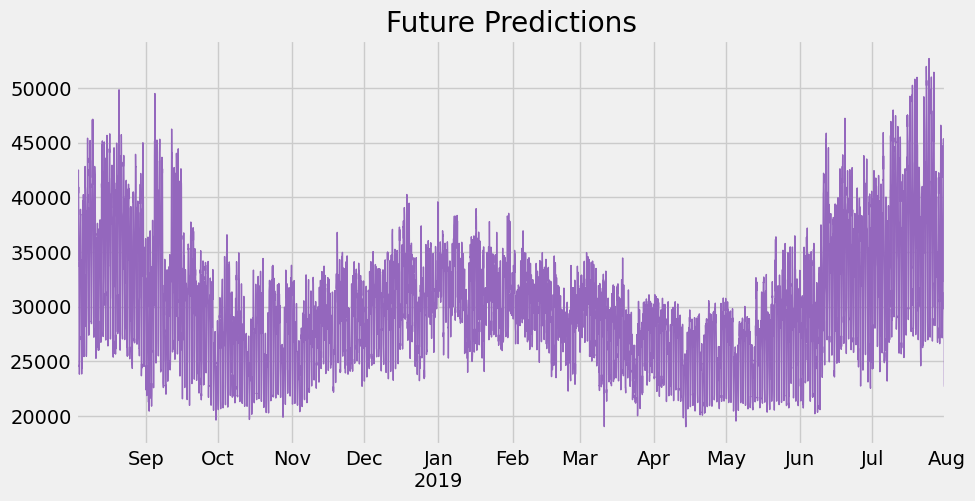

In [42]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()